# Tweeter Analysis Good Morning Kagglers !

Throughout this analysis we are going to see how to work with the tweeter's data. For that purpose I am divided this analysis into four parts.:

    1. Importation & cleaning
    2. Visualisation with WordCloud
    3. Tweet's sources
    4. Sentiment analysis
 

# 1. Importation & cleaning

In this section we are going to focus on the most important part of the analysis. In general rule the tweet are composed by several string that we have to clean before working correctly with the data. I have separated the importation of package into four parts. Usually numpy and pandas  are part of our toolbox. 

For the visualisation we use [Seaborn](https://seaborn.pydata.org/), [Matplotlib](https://matplotlib.org/), [Basemap](https://matplotlib.org/basemap/) and finall [word_cloud](https://github.com/amueller/word_cloud).
In order to clean our data (Text) and sentiment analysis the most common library is [NLTK](https://www.nltk.org/). NLTK is a leading platform Python programs to workin with human language data. It exists another Natural Language Toolkit ([gensim](https://radimrehurek.com/gensim/)) but in our case it is not necessary to use it.

The data with which are going to work is a list of tweets with the hashtag #goodmorning.


In [3]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None

%matplotlib inline

#Getting data
tweets = pd.read_csv('../input/tweets_all.csv', encoding = "ISO-8859-1")
display(tweets.head(3))

,Unnamed: 0,text,retweet_count,favorited,truncated,id_str,in_reply_to_screen_name,source,retweeted,created_at,...,place_type,full_name,place_name,place_id,place_lat,place_lon,lat,lon,expanded_url,url
0,7,Good morning. \r\n#njspots #toxictins #njshoot...,0,False,False,806435522684063744,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Wed Dec 07 09:49:46 +0000 2016,...,city,"Mercerville, NJ",NaN,NaN,40.227928,-74.703982,40.236494,-74.717857,http://fb.me/1vMVgkYg7,https://t.co/q7R11FO1eU
1,15,@DinaPugliese Good morning Dina :) Have a terr...,0,False,False,806435535132721152,DinaPugliese,"<a href=""http://twitter.com/download/android"" ...",False,Wed Dec 07 09:49:49 +0000 2016,...,city,"Cochrane, Ontario",NaN,NaN,49.145331,-81.073921,NaN,NaN,NaN,NaN
2,18,#good morning everyone. https://t.co/u6W1jI4tKz,0,False,False,806435538928594944,NaN,"<a href=""http://twitter.com/download/android"" ...",False,Wed Dec 07 09:49:49 +0000 2016,...,city,"Lawrence, IN",NaN,NaN,39.870397,-85.996819,NaN,NaN,NaN,NaN


The data is composed by 43 columns. But only few columns will be concerned by our analysis. In this analysis we are kept the column "text" which contains the tweet, the column "country" which contains the user's country, the column "source" which contains the user's device and finally the twos columns "place_lon", "place_lat" which contains the longitude and the latitude of the user.

In [4]:
tweets.columns

Index(['Unnamed: 0', 'text', 'retweet_count', 'favorited', 'truncated',
       'id_str', 'in_reply_to_screen_name', 'source', 'retweeted',
       'created_at', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str',
       'lang', 'listed_count', 'verified', 'location', 'user_id_str',
       'description', 'geo_enabled', 'user_created_at', 'statuses_count',
       'followers_count', 'favourites_count', 'protected', 'user_url', 'name',
       'time_zone', 'user_lang', 'utc_offset', 'friends_count', 'screen_name',
       'country_code', 'country', 'place_type', 'full_name', 'place_name',
       'place_id', 'place_lat', 'place_lon', 'lat', 'lon', 'expanded_url',
       'url'],
      dtype='object')

Here an example of the first column whereby we are going to start.

In [5]:
tweets['text'][1]

'@DinaPugliese Good morning Dina :) Have a terrific hump day! :) Little snowy in Cochrane today. https://t.co/P3j1dtUs6y'

You can see that in the first tweet we can find an URL, punctuations and a username of one tweetos (preceded by @). Before the data visualisation or the sentiment analysis it is necessary to clean the data. Delete the punctiuaton, the URL, put the test in a lower case, extract the username for example. It is possible to add more steps but in our case it won't be useful.

For the first step we are going to extract the username through the tweets (preceded by @ or by RT @). We keep this information in the column "tweetos".

In [6]:
#Preprocessing del RT @blablabla:
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])

In [7]:
tweets['text'][1]

'Good morning Dina :) Have a terrific hump day! :) Little snowy in Cochrane today.'

We can see that the first step of the cleaning it well done ! The username and the URL are deleteed correctly. Now we are going to delete certains punctuations, put the text in lower case and delete the double espace with the function apply.

In [8]:
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))

In [10]:
tweets['text'][1]

'good morning dina have a terrific hump day little snowy in cochrane today'

All step completed ! We have the tweets cleaned. Now we are going to do the second part.

# 2. Visualisation with WordCloud

Throughout this part we are going to focus on the kind of  data visualisation word cloud. It always interesting to do this kind of viz in order to have a global vision of the data.  The visualisation are going to do with the column "text" and "country".

In [11]:
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")

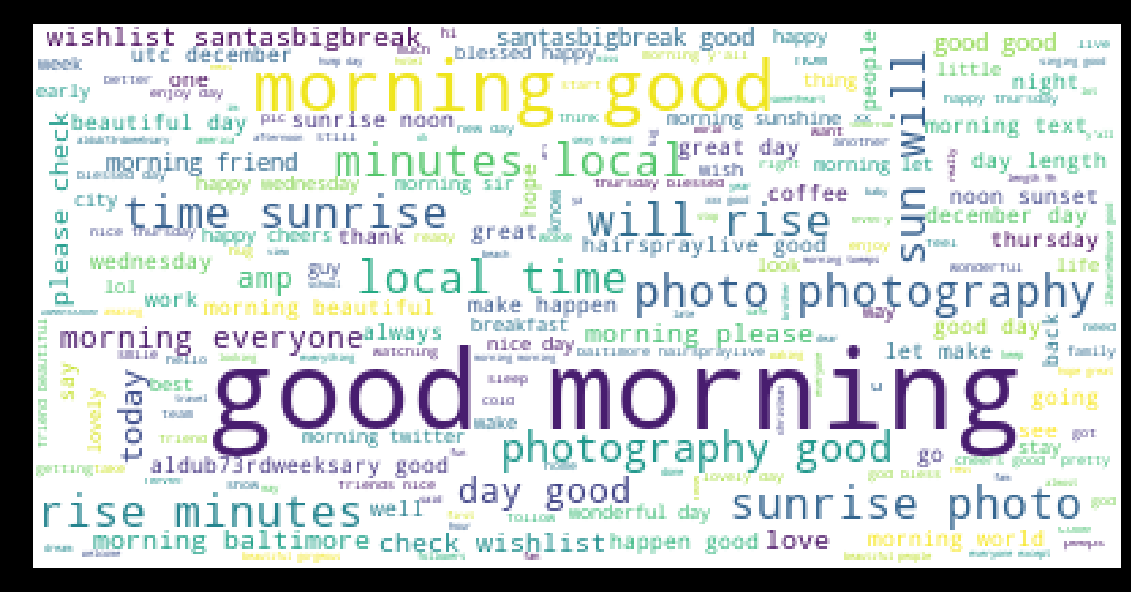

In [15]:
wordcloud(tweets,'text')  

In [13]:
tweets['country'] = tweets['country'].apply(lambda x: x.lower())
tweets['country'].replace('states united','united states',inplace=True)
tweets['country'].replace('united states','usa',inplace=True)
tweets['country'].replace('united Kingdom','uk',inplace=True)
tweets['country'].replace('republic philippines','philippines republic',inplace=True)

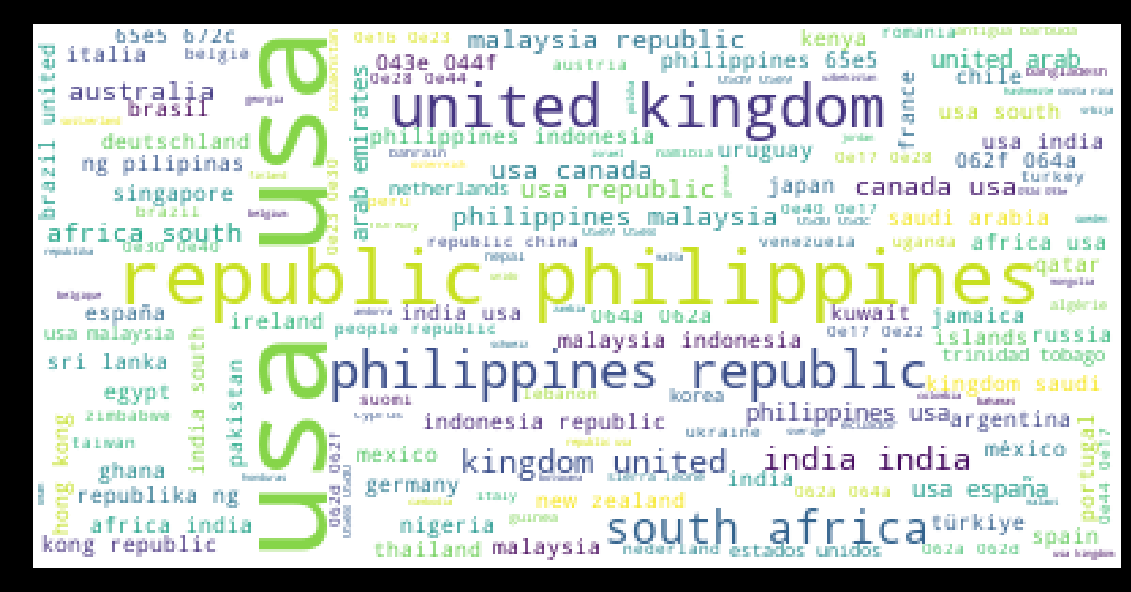

In [14]:
wordcloud(tweets, 'country')  

The most of tweets contains the wordd "good morning" (it is not surprising because the tweet are selected with the hashtag #goodmorning), photography, godd day, sunrise and so on. We can already think that the sentiment analysis will be positive in the most of cases. Regarding the information on the countries we can see that the most of tweets are sent  from United States, Philippines, United Kingdom and South Africa.

> # 3. Tweet's source

In this third part we are going to check the source of the tweets. And by the source I mean the device and the location. The purpose is to see the repartition of the tweet by deveice. As usual the first is the cleaning. The kind of device is situated at the end in the column "source". With the following example we can see that the device is just before "/a>".

In [16]:
tweets['source'][2]

'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'

In [17]:
tweets['source_new'] = ''

for i in range(len(tweets['source'])):
    m = re.search('(?<=>)(.*)', tweets['source'][i])
    try:
        tweets['source_new'][i]=m.group(0)
    except AttributeError:
        tweets['source_new'][i]=tweets['source'][i]
        
tweets['source_new'] = tweets['source_new'].str.replace('</a>', ' ', case=False)

We are going to create another column which will contain the source cleaned. Here the top five of the column "source_new".

In [18]:
tweets['source_new'].head()

0              Instagram 
1    Twitter for Android 
2    Twitter for Android 
3    Twitter for Android 
4     Twitter Web Client 
Name: source_new, dtype: object

What we interest us is the number of tweet by source. With the following lines we are going to compute this indicator.

In [19]:
tweets_by_type = tweets.groupby(['source_new'])['followers_count'].sum()

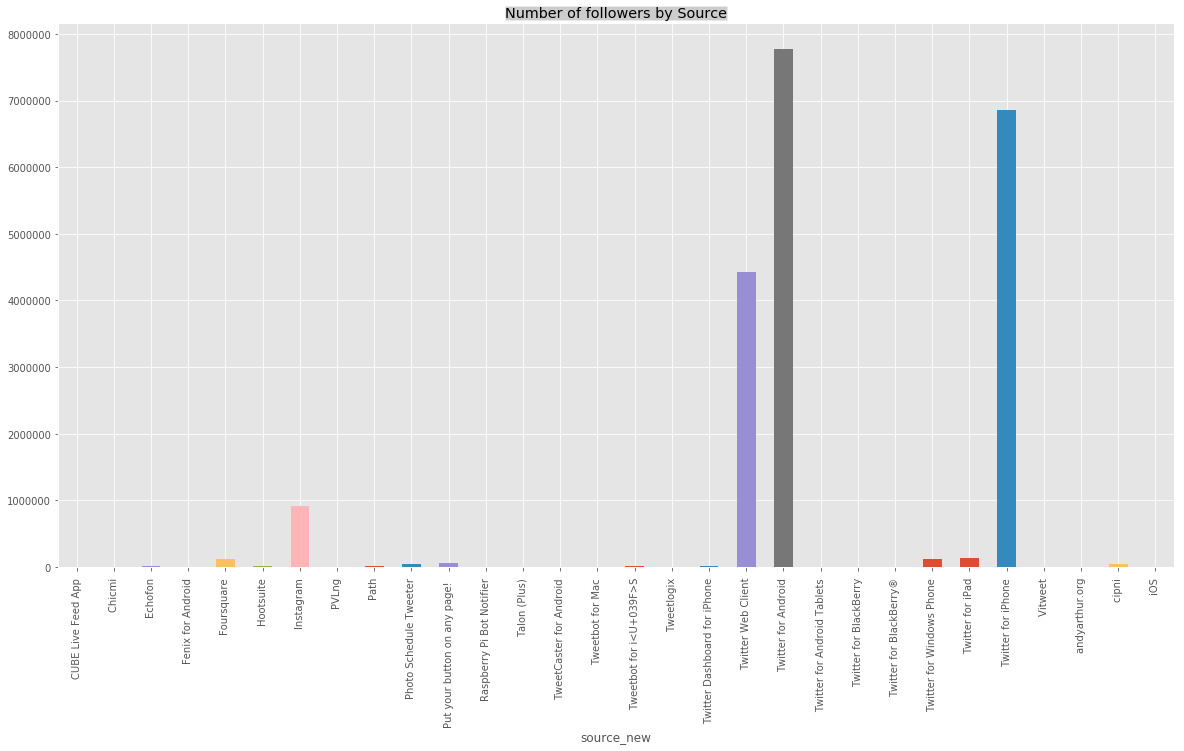

In [20]:
plt.title('Number of followers by Source', bbox={'facecolor':'0.8', 'pad':0})
tweets_by_type.transpose().plot(kind='bar',figsize=(20, 10))

Text(0.5,1,'Number of followers by Source bis')

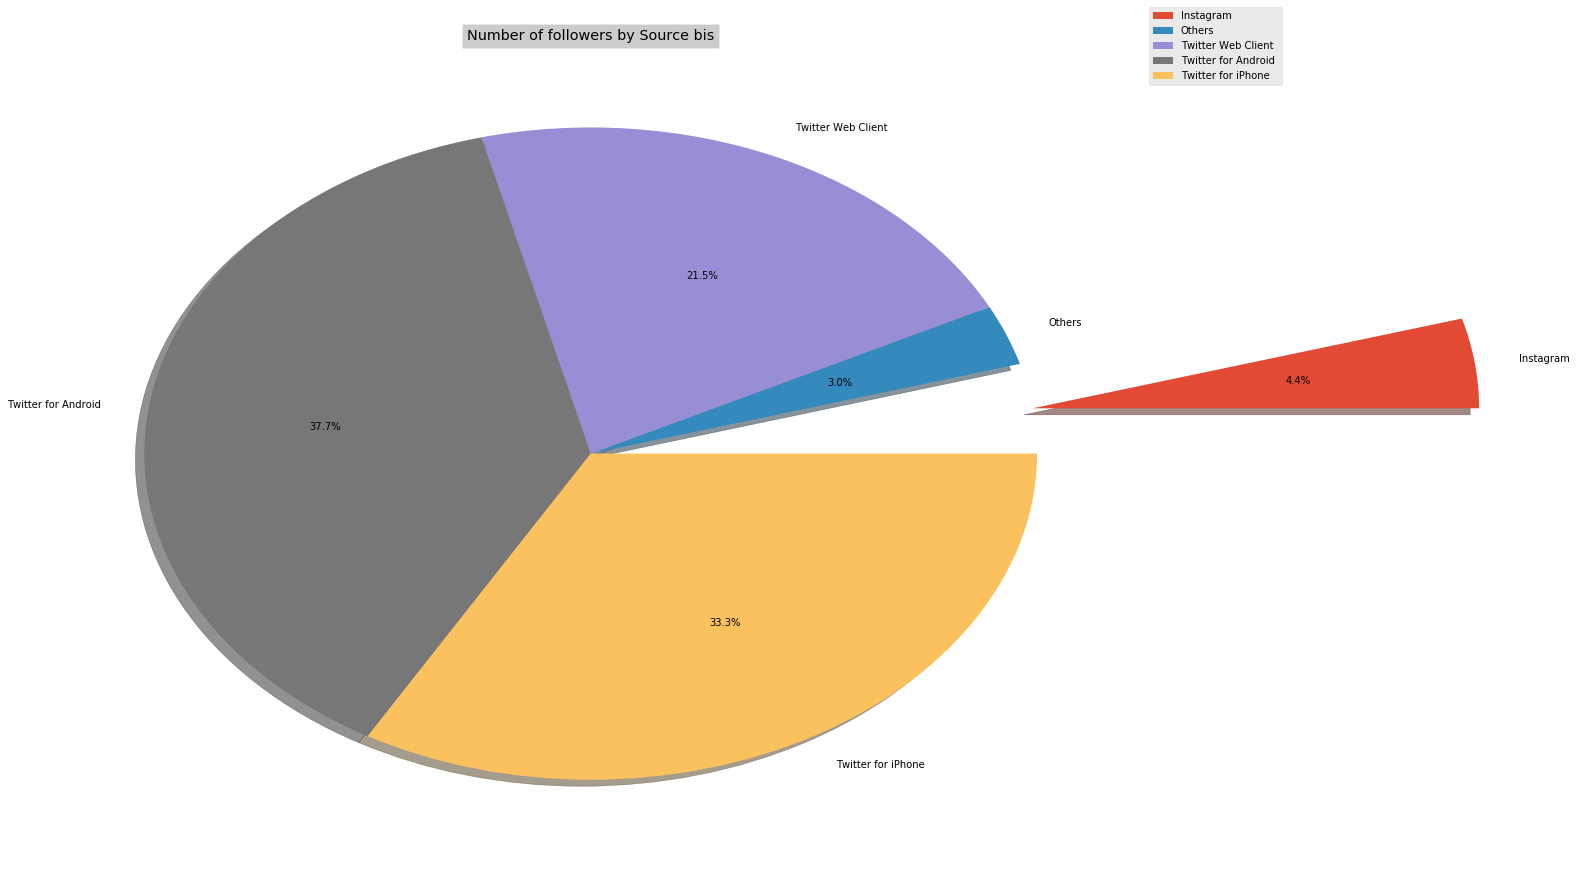

In [21]:
tweets['source_new2'] = ''

for i in range(len(tweets['source_new'])):
    if tweets['source_new'][i] not in ['Twitter for Android ','Instagram ','Twitter Web Client ','Twitter for iPhone ']:
        tweets['source_new2'][i] = 'Others'
    else:
        tweets['source_new2'][i] = tweets['source_new'][i] 

tweets_by_type2 = tweets.groupby(['source_new2'])['followers_count'].sum()

tweets_by_type2.rename("",inplace=True)
explode = (1, 0, 0, 0, 0)
tweets_by_type2.transpose().plot(kind='pie',figsize=(20, 15),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=6, borderaxespad=0.)
plt.title('Number of followers by Source bis', bbox={'facecolor':'0.8', 'pad':5})

These charts show us that the most important part of the tweet are sent through Iphone, Android and Webclient. And only 7% by Instagram and other devices. Now we are going to interest in the information of the localisation: longitude and latitude. To display this information through a visualisation we are going to use "Basemap". Each red point correspond to a location. 

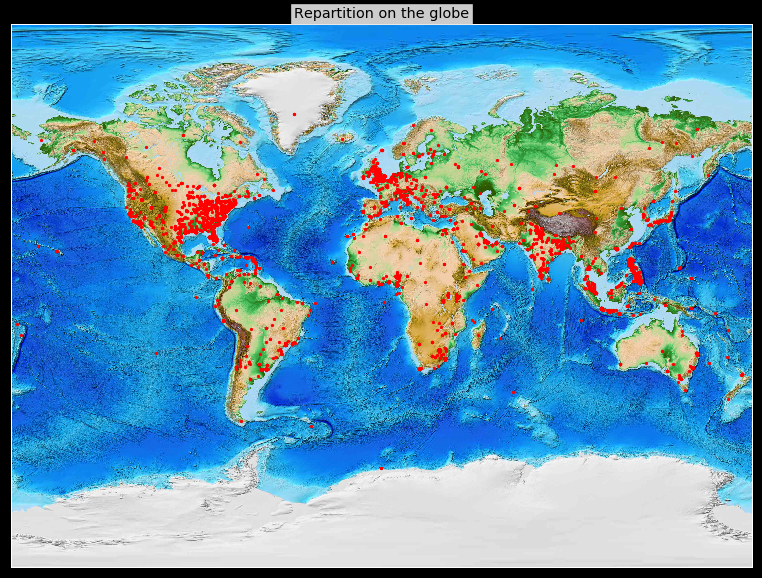

In [22]:
plt.figure( figsize=(20,10), facecolor='k')
m = Basemap(projection='mill',resolution=None,llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180)
m.etopo()
xpt,ypt = m(np.array(tweets['place_lon']),np.array(tweets['place_lat']))
lon,lat = m(xpt,ypt,inverse=True)
m.plot(xpt,ypt,'ro',markersize=np.sqrt(5)) 
plt.title('Repartition on the globe', bbox={'facecolor':'0.8', 'pad':3})
plt.show()

# 4. Sentiment Analysis

Throughout last part we are going to do an sentiment analysis.  The objective is to class by type th tweets. We are going to distingush 3 kind of tweets according to their polarity score. We will have the positive tweets, the neutral tweets and the negative tweets.

In [23]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(tweets['text_lem'].str.upper())

In [24]:
sid = SentimentIntensityAnalyzer()
tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

As we guessed the most of tweets are positive. We just can see 1.8% negative tweets.  

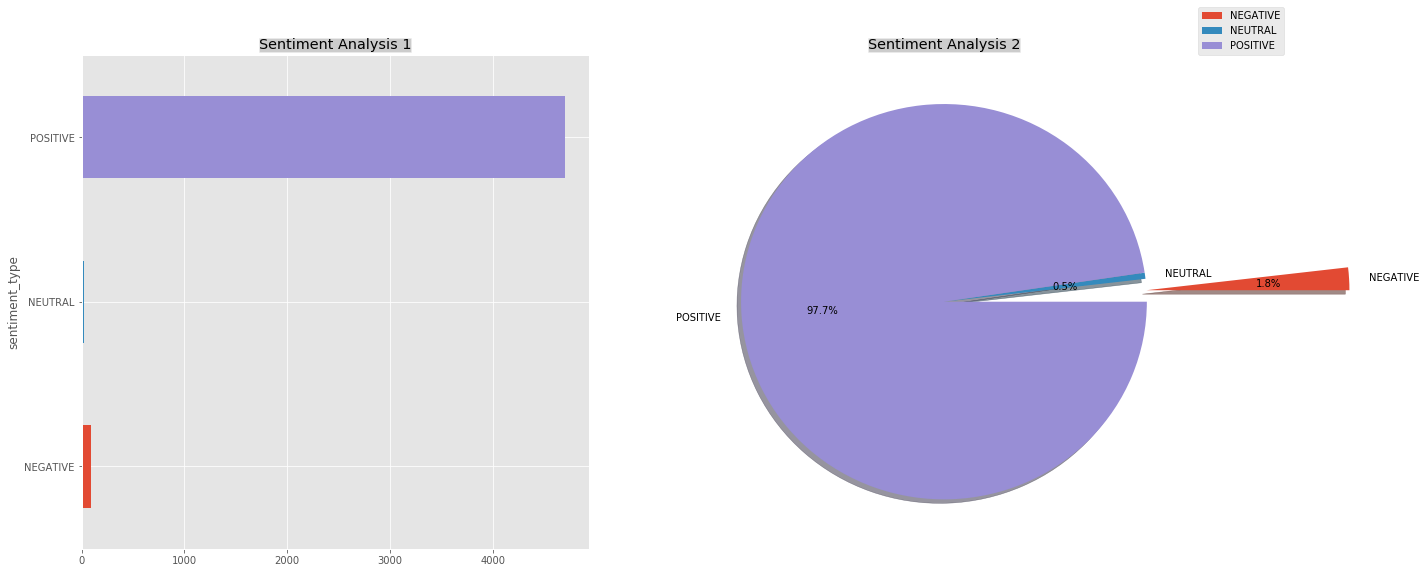

In [25]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

To conclude you can see the non comprehensive list of tweets which are considered negative. it will be interested to identify the words which contribute to put a negative sentiment.****

In [26]:
tweets[tweets.sentiment_type == 'NEGATIVE'].text.reset_index(drop = True)[0:5]

0    good morning it's time for pastries almond and...
1                                   good morning bitch
2    not a good look when you take a study break to...
3    good morning niece/ it's been awhile- miss you...
4                   good morning from hell that is all
Name: text, dtype: object